<a href="https://www.kaggle.com/code/amrmohamedsaber/artist-classification?scriptVersionId=186569319" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best-artworks-of-all-time/artists.csv
/kaggle/input/best-artworks-of-all-time/resized/resized/Peter_Paul_Rubens_132.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Albrecht_Dürer_59.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Andrei_Rublev_21.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Vincent_van_Gogh_586.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Peter_Paul_Rubens_9.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Vincent_van_Gogh_559.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Amedeo_Modigliani_169.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Vincent_van_Gogh_804.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Amedeo_Modigliani_71.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Frida_Kahlo_68.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Albrecht_Dürer_307.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Andy_Warhol_3

# imports

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,BatchNormalization, MaxPooling2D, Flatten, AveragePooling2D,Dropout,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.applications.vgg16 import VGG16
import keras_tuner as kt
from tensorflow.keras.applications import ResNet50,InceptionV3,DenseNet121,Xception,EfficientNetB1
from tensorflow.keras.layers import Input, Concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import Precision,Recall,F1Score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
import os
from glob import glob
import shutil
import random
from shutil import copyfile
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preproccessing

* **Choose top 15 Artists**

In [3]:
artists = pd.read_csv('../input/best-artworks-of-all-time/artists.csv')
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists.reset_index()
artists_top = artists.head(15).reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top


,name,paintings
0,Vincent van Gogh,877
1,Edgar Degas,702
2,Pablo Picasso,439
3,Pierre-Auguste Renoir,336
4,Albrecht Dürer,328
5,Paul Gauguin,311
6,Francisco Goya,291
7,Rembrandt,262
8,Alfred Sisley,259
9,Titian,255


* **Ensure that artists founded**

In [4]:
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

# Explore images of top artists
images_dir = '../input/best-artworks-of-all-time/images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> ../input/best-artworks-of-all-time/images/images/Vincent_van_Gogh
Found --> ../input/best-artworks-of-all-time/images/images/Edgar_Degas
Found --> ../input/best-artworks-of-all-time/images/images/Pablo_Picasso
Found --> ../input/best-artworks-of-all-time/images/images/Pierre-Auguste_Renoir
Found --> ../input/best-artworks-of-all-time/images/images/Albrecht_Dürer
Found --> ../input/best-artworks-of-all-time/images/images/Paul_Gauguin
Found --> ../input/best-artworks-of-all-time/images/images/Francisco_Goya
Found --> ../input/best-artworks-of-all-time/images/images/Rembrandt
Found --> ../input/best-artworks-of-all-time/images/images/Alfred_Sisley
Found --> ../input/best-artworks-of-all-time/images/images/Titian
Found --> ../input/best-artworks-of-all-time/images/images/Marc_Chagall
Found --> ../input/best-artworks-of-all-time/images/images/Rene_Magritte
Found --> ../input/best-artworks-of-all-time/images/images/Amedeo_Modigliani
Found --> ../input/best-artworks-of-all-time/ima

* **create directions to splite data in it**

In [5]:
try:
    ###########################################
    os.mkdir('/kaggle/working/artists')
    os.mkdir('/kaggle/working/artists/training')
    os.mkdir('/kaggle/working/artists/validation')
    os.mkdir('/kaggle/working/artists/test')
    
    ###########################################
    os.mkdir('/kaggle/working/artists/training/Titian')
    os.mkdir('/kaggle/working/artists/training/Alfred_Sisley')
    os.mkdir('/kaggle/working/artists/training/Rembrandt')
    os.mkdir('/kaggle/working/artists/training/Francisco_Goya')
    os.mkdir('/kaggle/working/artists/training/Paul_Gauguin')
    os.mkdir('/kaggle/working/artists/training/Albrecht_Dürer')
    os.mkdir('/kaggle/working/artists/training/Pierre-Auguste_Renoir')
    os.mkdir('/kaggle/working/artists/training/Pablo_Picasso')
    os.mkdir('/kaggle/working/artists/training/Edgar_Degas')
    os.mkdir('/kaggle/working/artists/training/Vincent_van_Gogh')
    os.mkdir('/kaggle/working/artists/training/Marc_Chagall')
    os.mkdir('/kaggle/working/artists/training/Rene_Magritte')
    os.mkdir('/kaggle/working/artists/training/Amedeo_Modigliani')
    os.mkdir('/kaggle/working/artists/training/Paul_Klee')
    os.mkdir('/kaggle/working/artists/training/Henri_Matisse')
     ###########################################
    os.mkdir('/kaggle/working/artists/validation/Titian')
    os.mkdir('/kaggle/working/artists/validation/Alfred_Sisley')
    os.mkdir('/kaggle/working/artists/validation/Rembrandt')
    os.mkdir('/kaggle/working/artists/validation/Francisco_Goya')
    os.mkdir('/kaggle/working/artists/validation/Paul_Gauguin')
    os.mkdir('/kaggle/working/artists/validation/Albrecht_Dürer')
    os.mkdir('/kaggle/working/artists/validation/Pierre-Auguste_Renoir')
    os.mkdir('/kaggle/working/artists/validation/Pablo_Picasso')
    os.mkdir('/kaggle/working/artists/validation/Edgar_Degas')
    os.mkdir('/kaggle/working/artists/validation/Vincent_van_Gogh')
    os.mkdir('/kaggle/working/artists/validation/Marc_Chagall')
    os.mkdir('/kaggle/working/artists/validation/Rene_Magritte')
    os.mkdir('/kaggle/working/artists/validation/Amedeo_Modigliani')
    os.mkdir('/kaggle/working/artists/validation/Paul_Klee')
    os.mkdir('/kaggle/working/artists/validation/Henri_Matisse')
    ############################################
    os.mkdir('/kaggle/working/artists/test/Titian')
    os.mkdir('/kaggle/working/artists/test/Alfred_Sisley')
    os.mkdir('/kaggle/working/artists/test/Rembrandt')
    os.mkdir('/kaggle/working/artists/test/Francisco_Goya')
    os.mkdir('/kaggle/working/artists/test/Paul_Gauguin')
    os.mkdir('/kaggle/working/artists/test/Albrecht_Dürer')
    os.mkdir('/kaggle/working/artists/test/Pierre-Auguste_Renoir')
    os.mkdir('/kaggle/working/artists/test/Pablo_Picasso')
    os.mkdir('/kaggle/working/artists/test/Edgar_Degas')
    os.mkdir('/kaggle/working/artists/test/Vincent_van_Gogh')
    os.mkdir('/kaggle/working/artists/test/Marc_Chagall')
    os.mkdir('/kaggle/working/artists/test/Rene_Magritte')
    os.mkdir('/kaggle/working/artists/test/Amedeo_Modigliani')
    os.mkdir('/kaggle/working/artists/test/Paul_Klee')
    os.mkdir('/kaggle/working/artists/test/Henri_Matisse')
    ############################################
except OSError:
    print('Error failed to make directory')
    

In [6]:
##########################################################
Vincent_van_Gogh_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Vincent_van_Gogh'
Edgar_Degas_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Edgar_Degas'
Pablo_Picasso_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Pablo_Picasso'
Pierre_Auguste_Renoir_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Pierre-Auguste_Renoir'
Albrecht_Dürer_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Albrecht_Dürer'
Paul_Gauguin_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Paul_Gauguin'
Francisco_Goya_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Francisco_Goya'
Rembrandt_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Rembrandt'
Alfred_Sisley_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Alfred_Sisley'
Titian_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Titian'
Marc_Chagall_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Marc_Chagall'
Rene_Magritte_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Rene_Magritte'
Amedeo_Modigliani_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Amedeo_Modigliani'
Paul_Klee_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Paul_Klee'
Henri_Matisse_DIR = '/kaggle/input/best-artworks-of-all-time/images/images/Henri_Matisse'

* **Function to split and copy data**

In [7]:
def split_data(main_dir, training_dir, validation_dir, test_dir,  split_size, random_seed=42):
    # Check if main_dir is not None
    if main_dir is None:
        print("Error: main_dir cannot be None")
        return
    # Get the list of all files in the main directory
    all_files = [file for file in os.listdir(main_dir) if os.path.getsize(os.path.join(main_dir, file)) > 0]

    # Split the data into training and validation and test sets
    train_files, remaining_files = train_test_split(all_files, train_size=split_size, random_state=random_seed)
    validation_files, test_files = train_test_split(remaining_files, test_size=0.5, random_state=random_seed)
   

    # Copy files to their respective directories
    copy_files(main_dir, training_dir, train_files)
    copy_files(main_dir, validation_dir, validation_files)
    copy_files(main_dir, test_dir, test_files)

    print("Split successful!")

def copy_files(source_dir, destination_dir, file_list):
    # Copy files from source to destination
    for file in file_list:
        source_path = os.path.join(source_dir, file)
        destination_path = os.path.join(destination_dir, file)
        shutil.copyfile(source_path, destination_path)

In [8]:
split_data(Vincent_van_Gogh_DIR, "/kaggle/working/artists/training/Vincent_van_Gogh", "/kaggle/working/artists/validation/Vincent_van_Gogh", "/kaggle/working/artists/test/Vincent_van_Gogh", 0.8)
split_data(Edgar_Degas_DIR, "/kaggle/working/artists/training/Edgar_Degas", "/kaggle/working/artists/validation/Edgar_Degas","/kaggle/working/artists/test/Edgar_Degas", 0.8)
split_data(Pablo_Picasso_DIR, "/kaggle/working/artists/training/Pablo_Picasso", "/kaggle/working/artists/validation/Pablo_Picasso","/kaggle/working/artists/test/Pablo_Picasso", 0.8)
split_data(Pierre_Auguste_Renoir_DIR, "/kaggle/working/artists/training/Pierre-Auguste_Renoir", "/kaggle/working/artists/validation/Pierre-Auguste_Renoir", "/kaggle/working/artists/test/Pierre-Auguste_Renoir", 0.6)
split_data(Albrecht_Dürer_DIR, "/kaggle/working/artists/training/Albrecht_Dürer", "/kaggle/working/artists/validation/Albrecht_Dürer", "/kaggle/working/artists/test/Albrecht_Dürer", 0.8)
split_data(Paul_Gauguin_DIR, "/kaggle/working/artists/training/Paul_Gauguin", "/kaggle/working/artists/validation/Paul_Gauguin", "/kaggle/working/artists/test/Paul_Gauguin", 0.8)
split_data(Francisco_Goya_DIR, "/kaggle/working/artists/training/Francisco_Goya", "/kaggle/working/artists/validation/Francisco_Goya","/kaggle/working/artists/test/Francisco_Goya", 0.8)
split_data(Rembrandt_DIR, "/kaggle/working/artists/training/Rembrandt", "/kaggle/working/artists/validation/Rembrandt","/kaggle/working/artists/test/Rembrandt", 0.8)
split_data(Alfred_Sisley_DIR, "/kaggle/working/artists/training/Alfred_Sisley", "/kaggle/working/artists/validation/Alfred_Sisley", "/kaggle/working/artists/test/Alfred_Sisley", 0.8)
split_data(Titian_DIR, "/kaggle/working/artists/training/Titian", "/kaggle/working/artists/validation/Titian", "/kaggle/working/artists/test/Titian", 0.8)
split_data(Marc_Chagall_DIR, "/kaggle/working/artists/training/Marc_Chagall", "/kaggle/working/artists/validation/Marc_Chagall", "/kaggle/working/artists/test/Marc_Chagall", 0.8)
split_data(Rene_Magritte_DIR, "/kaggle/working/artists/training/Rene_Magritte", "/kaggle/working/artists/validation/Rene_Magritte", "/kaggle/working/artists/test/Rene_Magritte", 0.8)
split_data(Amedeo_Modigliani_DIR, "/kaggle/working/artists/training/Amedeo_Modigliani", "/kaggle/working/artists/validation/Amedeo_Modigliani", "/kaggle/working/artists/test/Amedeo_Modigliani", 0.8)
split_data(Paul_Klee_DIR, "/kaggle/working/artists/training/Paul_Klee", "/kaggle/working/artists/validation/Paul_Klee", "/kaggle/working/artists/test/Paul_Klee", 0.8)
split_data(Henri_Matisse_DIR, "/kaggle/working/artists/training/Henri_Matisse", "/kaggle/working/artists/validation/Henri_Matisse", "/kaggle/working/artists/test/Henri_Matisse", 0.8)

Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!
Split successful!


* **create train, test, validate generators**

In [9]:
train_gen = ImageDataGenerator(
                                   rescale=1./255,             # rescale pixel values between 0 and 1
                                   rotation_range=20,          # rotation range in degrees
                                   width_shift_range=0.2,      # fraction of total width for horizontal shift
                                   height_shift_range=0.2,     # fraction of total height for vertical shift
                                   shear_range=0.2,            # shear intensity
                                   zoom_range=0.2,             # random zoom range
                                   horizontal_flip=True,       # randomly flip inputs horizontally
                                   fill_mode='nearest'
                   )


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

test_gen =  ImageDataGenerator(
            rescale=1./255.)
train_generator = train_gen.flow_from_directory(
        '/kaggle/working/artists/training',
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical")
validation_generator = validation_gen.flow_from_directory(
        '/kaggle/working/artists/validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical")

test_generator = test_gen.flow_from_directory(
        '/kaggle/working/artists/test',
        target_size=(224, 224),
        batch_size=32,
        shuffle= False,
        class_mode="categorical")

Found 3974 images belonging to 15 classes.
Found 539 images belonging to 15 classes.
Found 547 images belonging to 15 classes.


# Model

In [13]:
# Define input
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Load Xception model
xception_model = Xception(include_top=False, weights='imagenet', input_tensor=inputs)
for layer in xception_model.layers:
    layer.trainable = False
xception_features = GlobalAveragePooling2D()(xception_model.output)

# Load DenseNet121 model
densenet_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=inputs)
for layer in densenet_model.layers:
    layer.trainable = False
densenet_features = GlobalAveragePooling2D()(densenet_model.output)

# Concatenate features
combined_features = Concatenate()([xception_features, densenet_features])

# Add classifier on top
x = Dense(1024, activation='relu')(combined_features)
x = Dense(512, activation='relu')(x)
outputs = Dense(15, activation='softmax')(x)  # Assuming 10 classes for classification

# Create model
model = Model(inputs=inputs, outputs=outputs)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [14]:
# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

In [15]:
result=model.fit(
        train_generator,
        epochs=10,
        workers=5,
        use_multiprocessing = True,
        validation_data=validation_generator,
        shuffle=True)

Epoch 1/10
125/125 [==============================] - 67s 435ms/step - loss: 1.6398 - accuracy: 0.4653 - val_loss: 1.4629 - val_accuracy: 0.5473
Epoch 2/10
125/125 [==============================] - 51s 390ms/step - loss: 1.0171 - accuracy: 0.6623 - val_loss: 0.9108 - val_accuracy: 0.6957
Epoch 3/10
125/125 [==============================] - 51s 394ms/step - loss: 0.8412 - accuracy: 0.7237 - val_loss: 0.9871 - val_accuracy: 0.6939
Epoch 4/10
125/125 [==============================] - 51s 397ms/step - loss: 0.6949 - accuracy: 0.7640 - val_loss: 0.9169 - val_accuracy: 0.7328
Epoch 5/10
125/125 [==============================] - 49s 379ms/step - loss: 0.6152 - accuracy: 0.7904 - val_loss: 0.9046 - val_accuracy: 0.7236
Epoch 6/10
125/125 [==============================] - 50s 377ms/step - loss: 0.5456 - accuracy: 0.8171 - val_loss: 0.8184 - val_accuracy: 0.7514
Epoch 7/10
125/125 [==============================] - 48s 373ms/step - loss: 0.5097 - accuracy: 0.8306 - val_loss: 0.9187 - val_ac

# Evaluation

In [18]:
for layer in xception_model.layers[-50:]:
    layer.trainable = True
for layer in densenet_model.layers[-50:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [19]:
result = model.fit(
        train_generator,
        epochs=50,
        workers = 5,
        use_multiprocessing = True,
        callbacks=[reduce_lr,early_stop],
        validation_data=validation_generator)

Epoch 1/50
125/125 [==============================] - 84s 440ms/step - loss: 0.4473 - accuracy: 0.8488 - val_loss: 0.9766 - val_accuracy: 0.7588 - lr: 1.0000e-04
Epoch 2/50
125/125 [==============================] - 54s 417ms/step - loss: 0.2661 - accuracy: 0.9094 - val_loss: 0.8200 - val_accuracy: 0.7737 - lr: 1.0000e-04
Epoch 3/50
125/125 [==============================] - 54s 417ms/step - loss: 0.1888 - accuracy: 0.9396 - val_loss: 0.7391 - val_accuracy: 0.8200 - lr: 1.0000e-04
Epoch 4/50
125/125 [==============================] - 54s 410ms/step - loss: 0.1405 - accuracy: 0.9540 - val_loss: 0.7195 - val_accuracy: 0.8256 - lr: 1.0000e-04
Epoch 5/50
125/125 [==============================] - 55s 422ms/step - loss: 0.1360 - accuracy: 0.9529 - val_loss: 0.7640 - val_accuracy: 0.8033 - lr: 1.0000e-04
Epoch 6/50
125/125 [==============================] - 54s 418ms/step - loss: 0.1001 - accuracy: 0.9698 - val_loss: 0.7285 - val_accuracy: 0.8293 - lr: 1.0000e-04
Epoch 7/50
125/125 [========

18/18 [==============================] - 8s 253ms/step
Classification Report:
                        precision    recall  f1-score   support

      Albrecht_Dürer       0.89      1.00      0.94        33
        Alfred_Sisley       0.83      0.77      0.80        26
    Amedeo_Modigliani       0.95      0.90      0.92        20
          Edgar_Degas       0.86      0.87      0.87        71
       Francisco_Goya       0.82      0.77      0.79        30
        Henri_Matisse       0.93      0.74      0.82        19
         Marc_Chagall       0.88      0.58      0.70        24
        Pablo_Picasso       0.73      0.84      0.78        44
         Paul_Gauguin       0.76      0.88      0.81        32
            Paul_Klee       0.88      0.79      0.83        19
Pierre-Auguste_Renoir       0.98      0.75      0.85        68
            Rembrandt       0.96      0.85      0.90        27
        Rene_Magritte       0.94      0.80      0.86        20
               Titian       0.86      

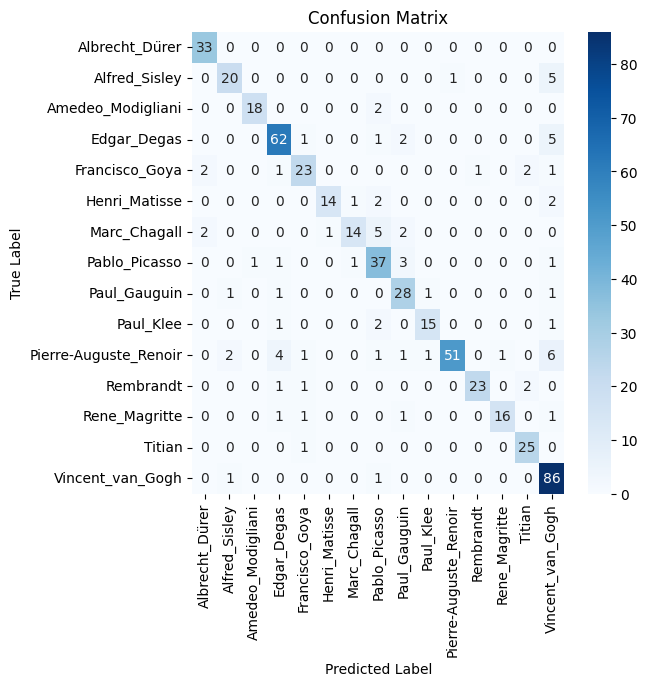

In [20]:
accurecy = model.evaluate(test_generator)

# Generate predictions
y_pred_prob = model.predict(test_generator)  # Predict probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)       # Convert probabilities to class labels

# Assuming test_generator has ground truth labels
y_true = test_generator.classes

# Calculate classification report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)

print("Classification Report:\n", report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
def display_image_grid(model, test_generator, train_generator, n=9, num_cols=3):
    num_rows = (n + num_cols - 1) // num_cols  # Calculate the number of rows needed
    test_images_dir = '/kaggle/working/artists/test'

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6))

    for i in range(n):
        row = i // num_cols
        col = i % num_cols

        random_style = random.choice(list(test_generator.class_indices.keys()))
        random_image = random.choice(os.listdir(os.path.join(test_images_dir, random_style)))
        random_image_file = os.path.join(test_images_dir, random_style, random_image)

        # Load and preprocess the image
        test_image = image.load_img(random_image_file, target_size=(224, 224, 3))
        test_image = image.img_to_array(test_image)
        test_image /= 255.0
        test_image = np.expand_dims(test_image, axis=0)

        # Predict artist
        prediction = model.predict(test_image)
        prediction_probability = np.amax(prediction)
        prediction_idx = np.argmax(prediction)

        labels = train_generator.class_indices
        labels = {v: k for k, v in labels.items()}

        predicted_style = labels[prediction_idx].replace('_', ' ')
        actual_style = random_style.replace('_', ' ')

        # Set text color based on prediction accuracy
        text_color = 'green' if predicted_style == actual_style else 'red'

        title = "Actual Style = {}\nPredicted Style = {}\nPrediction probability = {:.2f} %" \
            .format(actual_style, predicted_style, prediction_probability * 100)

        # Display the image
        if num_rows == 1:
            axes[col].imshow(plt.imread(random_image_file))
            axes[col].set_title(title, fontsize=8, color=text_color)
            axes[col].axis('off')
        else:
            axes[row, col].imshow(plt.imread(random_image_file))
            axes[row, col].set_title(title, fontsize=8, color=text_color)
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 50ms/step


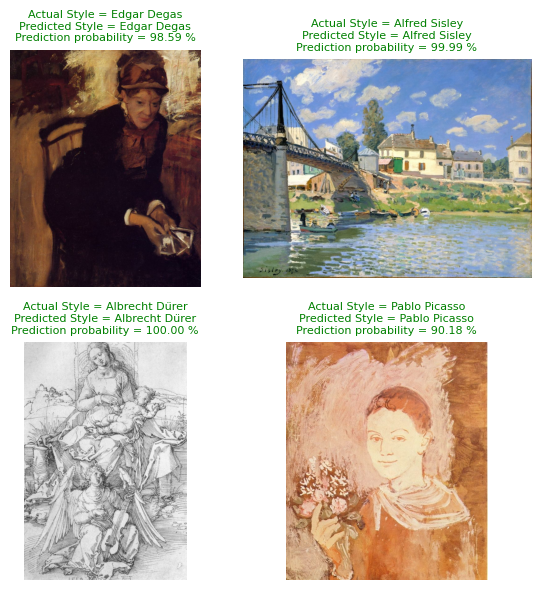

In [25]:
display_image_grid(model,test_generator,train_generator, n=4, num_cols=2)

In [ ]:
import tensorflow as tf
from tensorflow import lite
from tensorflow.keras.models import load_model

converter = lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()
with open('/kaggle/working/artist_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
# Get the unique labels
unique_labels = list(test_generator.class_indices.keys())

# Write the labels to a text file
with open('labels.txt', 'w') as f:
    for label in unique_labels:
        formatted_label = label.replace('_', ' ')
        f.write(str(formatted_label) + '\n')